## **Predicting Dyslexia Disease**

- This Notebook contains different AI Approaches i.e Deep Learning, Machine Learning & Transfer Learning in order to predict dylexia disease. 

- There are 2 types of dataset Train and Test each contains image dataset of english letters

### Import the Necessary Libraries For the Project

In [1]:
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import pickle
import torch
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("GPU available")
else:
    print("GPU not available")


GPU available


### Data Preparation and Preprocessing

- Prepare the dataset for the models

- Read the dataset and Labels it Properly

    - Normal = 0
    - Correlated = 1
    - Reversal = 2


In [3]:
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

    def __getitem__(self, index):
        path, _ = self.samples[index]
        # Extract class from directory structure
        class_name = os.path.basename(os.path.dirname(path))
        # Map class name to label
        if class_name == 'Normal':
            label = 0
        elif class_name == 'Correlated':
            label = 1
        elif class_name == 'Reversal':
            label = 2
        else:
            raise ValueError(f"Unknown class: {class_name}")

        # Load image
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [4]:
def load_data(data_dir, batch_size=32, shuffle=True):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transforms for preprocessing images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),   # Resize images to 224x224
        transforms.Grayscale(),          # Convert images to grayscale
        transforms.ToTensor(),           # Convert images to PyTorch tensors
    ])

    # Load images and labels using CustomImageFolder
    dataset = CustomImageFolder(data_dir, transform=transform)

    # Create a PyTorch dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader


In [5]:
# Paths to train and test directories
train_dir = './Data/Train'
test_dir = './Data/Test'
sample_dir = './Data/Samples'

In [6]:
# Read train data with labels
train_loader = load_data(train_dir)

In [7]:
# Read test data with labels
test_loader = load_data(test_dir)

In [5]:
# Read Samples data with labels
sample_loader = load_data(sample_dir)

In [23]:
len(train_loader.dataset)

151649

In [24]:
len(test_loader.dataset)

56723

#### Prepared Train Data with its Labels

In [8]:
# Calculate the number of batches needed to ensure divisibility by 60
num_batches_needed = 60

# Read the data and labels
train_data_batches = []
train_labels_batches = []
total_batches = 0
for data, labels in train_loader:
    if total_batches < num_batches_needed:
        train_data_batches.append(data)
        train_labels_batches.append(labels)
        total_batches += 1
    else:
        break

In [9]:
# Concatenate data and labels
train_data = torch.cat(train_data_batches, dim=0)
train_labels = torch.cat(train_labels_batches, dim=0)

#### Get Test Data along with Labels

In [10]:
# Calculate the number of batches needed to ensure divisibility by 60
num_batches_needed = 30

# Read the data and labels
test_data_batches = []
test_labels_batches = []
total_batches = 0
for data, labels in test_loader:
    if total_batches < num_batches_needed:
        test_data_batches.append(data)
        test_labels_batches.append(labels)
        total_batches += 1
    else:
        break

In [11]:
# Concatenate data and labels
test_data = torch.cat(test_data_batches, dim=0)
test_labels = torch.cat(test_labels_batches, dim=0)

In [6]:
# Extract samples data and labels
sample_data = torch.cat([data for data, _ in sample_loader], dim=0)
sample_labels = torch.cat([labels for _, labels in sample_loader], dim=0)

#### Plot some samples

In [11]:
# Plot some sample images
def plot_sample_images(data, labels, label_to_plot, num_samples=5):
    # Get indices of samples with the specified label
    indices = (labels == label_to_plot).nonzero().squeeze(1)
    # Randomly select num_samples indices
    selected_indices = torch.randint(0, indices.size(0), (num_samples,))
    # Plot sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(selected_indices):
        axes[i].imshow(data[indices[idx]].permute(1, 2, 0))  # Convert tensor to numpy array for imshow
        axes[i].axis('off')
        axes[i].set_title(f'Label {label_to_plot}')
    plt.show()

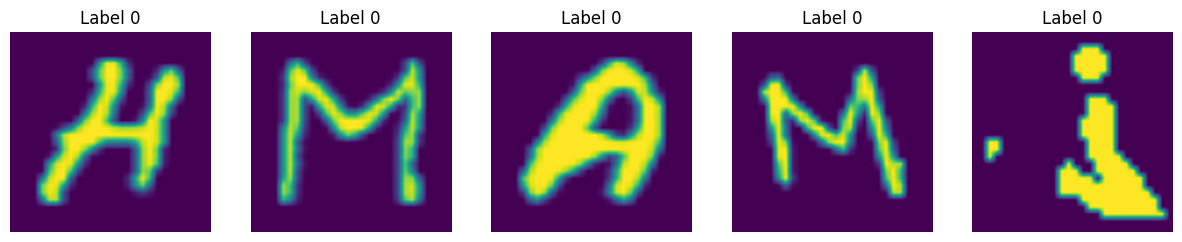

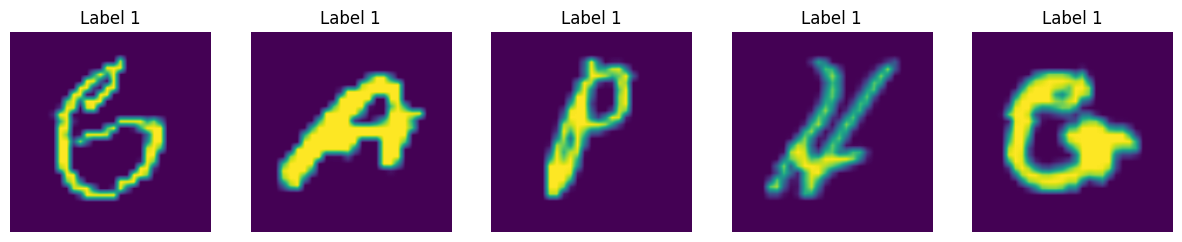

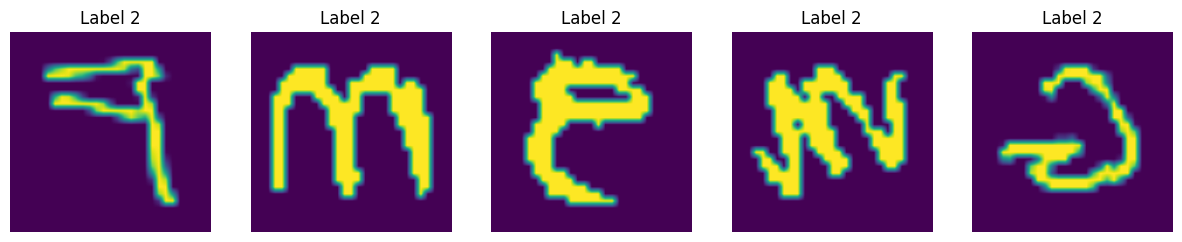

In [37]:
# Plot sample images for label 0 (Normal)
plot_sample_images(train_data, train_labels, label_to_plot=0)
# Plot sample images for label 1 (Correlated)
plot_sample_images(test_data, test_labels, label_to_plot=1)
# Plot sample images for label 2 (Reversal)
plot_sample_images(train_data, train_labels, label_to_plot=2)

## **Deep Learning Approach**

In [12]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

2024-03-25 23:24:23.344853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 23:24:27.294955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
# Check GPU availability
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


2024-03-25 23:24:51.976321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 23:24:51.998132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 23:24:51.998803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
# Define the architecture of the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [17]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
# Reshape input data to match expected shape (batch_size, height, width, channels)
train_data_np = train_data.permute(0, 2, 3, 1).numpy()
train_labels_np = train_labels.numpy()

In [23]:
# Train the model
history = model.fit(train_data_np, train_labels_np, epochs=10, validation_split=0.2)

Epoch 1/10


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [16]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
           Dropout-7               [-1, 100352]               0
            Linear-8                  [-1, 512]      51,380,736
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 128]          65,664
           Linear-11                    [-1, 3]             387
Total params: 51,539,459
Trainable params: 51,539,459
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Fo